# Using FISSA with Suite2p

[suite2p](https://github.com/MouseLand/suite2p) is a blind source separation toolbox for cell detection and signal extraction. 

Here we illustrate how to use suite2p to detect cell locations, and then use FISSA to remove neuropil signals from the ROI signals.

The suite2p parts of this tutorial are based on their [Jupyter notebook example](https://github.com/MouseLand/suite2p/blob/master/jupyter/run_pipeline_tiffs_or_batch.ipynb).

Note that the below results are not representative of either suite2p or FISSA performance, as we are using a very small example dataset.

**Reference:**
Pachitariu, M., Stringer, C., Dipoppa, M., Schröder, S., Rossi, L. F., Dalgleish, H., Carandini, M. & Harris, K. D. (2017). Suite2p: beyond 10,000 neurons with standard two-photon microscopy. bioRxiv:&nbsp;[061507](https://www.biorxiv.org/content/10.1101/061507v2); doi:&nbsp;[10.1101/061507](https://doi.org/10.1101/061507).

### Import packages

In [1]:
# FISSA toolbox
import fissa

# suite2p toolbox
import suite2p

# For plotting our results, use numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Run suite2p

In [2]:
# Set your options for running
ops = suite2p.default_ops()  # populates ops with the default options

# Provide an h5 path in 'h5py' or a tiff path in 'data_path'
# db overwrites any ops (allows for experiment specific settings)
db = {
    "h5py": [],  # a single h5 file path
    "h5py_key": "data",
    "look_one_level_down": False,  # whether to look in ALL subfolders when searching for tiffs
    "data_path": ["exampleData/20150529"],  # a list of folders with tiffs
    # (or folder of folders with tiffs if look_one_level_down is True,
    # or subfolders is not empty)
    "save_path0": "./",  # save path
    "subfolders": [],  # choose subfolders of 'data_path' to look in (optional)
    "fast_disk": "./",  # specify where the binary file will be stored (should be an SSD)
    "reg_tif": True,  # save the motion corrected tiffs
    "tau": 0.7,  # timescale of gcamp6f
    "fs": 1,  # sampling rate
    "spatial_scale": 10,  # rough guess of spatial scale cells
    "batch_size": 288,  # length in frames of each trial
}

# Run one experiment
opsEnd = suite2p.run_s2p(ops=ops, db=db)

{'h5py': [], 'h5py_key': 'data', 'look_one_level_down': False, 'data_path': ['exampleData/20150529'], 'save_path0': './', 'subfolders': [], 'fast_disk': './', 'reg_tif': True, 'tau': 0.7, 'fs': 1, 'spatial_scale': 10, 'batch_size': 288}
tif
** Found 3 tifs - converting to binary **
time 0.53 sec. Wrote 864 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 864 frames
Reference frame, 4.05 sec.
added enhanced mean image
----------- Total 11.24 sec
NOTE: Applying builtin classifier at ~/miniconda/envs/suite2p-fissa/lib/python3.7/site-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 01
Binned movie [500,172,152] in 0.07 sec.
NOTE: FORCED spatial scale ~48 pixels, time epochs 1.00, threshold 20.00 
0 ROIs, score=237.58
Detected 23 ROIs, 0.57 sec
After removi

## Load the relevant data from the analysis

In [3]:
# Extract the motion corrected tiffs (make sure that the reg_tif option is set to true, see above)
images = "./suite2p/plane0/reg_tif"

# Load the detected regions of interest
stat = np.load("./suite2p/plane0/stat.npy", allow_pickle=True)  # cell stats
ops = np.load("./suite2p/plane0/ops.npy", allow_pickle=True).item()
iscell = np.load("./suite2p/plane0/iscell.npy", allow_pickle=True)[:, 0]

# Get image size
Lx = ops["Lx"]
Ly = ops["Ly"]

# Get the cell ids
ncells = len(stat)
cell_ids = np.arange(ncells)  # assign each cell an ID, starting from 0.
cell_ids = cell_ids[iscell == 1]  # only take the ROIs that are actually cells.
num_rois = len(cell_ids)

# Generate ROI masks in a format usable by FISSA (in this case, a list of masks)
rois = [np.zeros((Ly, Lx), dtype=bool) for n in range(num_rois)]

for i, n in enumerate(cell_ids):
    # i is the position in cell_ids, and n is the actual cell number
    ypix = stat[n]["ypix"][~stat[n]["overlap"]]
    xpix = stat[n]["xpix"][~stat[n]["overlap"]]
    rois[i][ypix, xpix] = 1

## Run FISSA with the defined ROIs and data

In [4]:
output_folder = "fissa_suite2p_example"
experiment = fissa.Experiment(images, [rois[:ncells]], output_folder)
experiment.separate()

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 21 ROIs across 3 trials in 0.317 seconds.
Saving extracted traces to fissa_suite2p_example/prepared.npz


Separating data:   0%|          | 0/21 [00:00<?, ?it/s]

Finished separating signals from 21 ROIs across 3 trials in 5.47 seconds
Saving results to fissa_suite2p_example/separated.npz


## Plot the resulting ROI signals

In [5]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
cmap = plt.get_cmap("Paired")

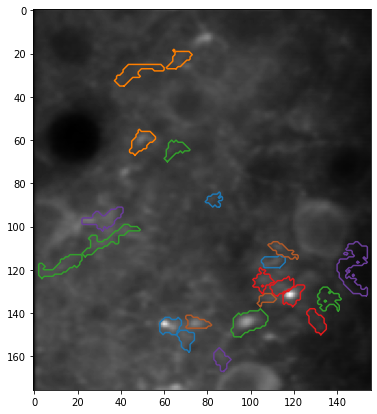

In [6]:
# Select which trial (TIFF index) to plot
trial = 0

# Plot the mean image and ROIs from the FISSA experiment
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")

XLIM = plt.xlim()
YLIM = plt.ylim()

for i_roi in range(len(experiment.roi_polys)):
    # Plot border around ROI
    for contour in experiment.roi_polys[i_roi, trial][0]:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )

# ROI co-ordinates are half a pixel outside the image,
# so we reset the axis limits
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

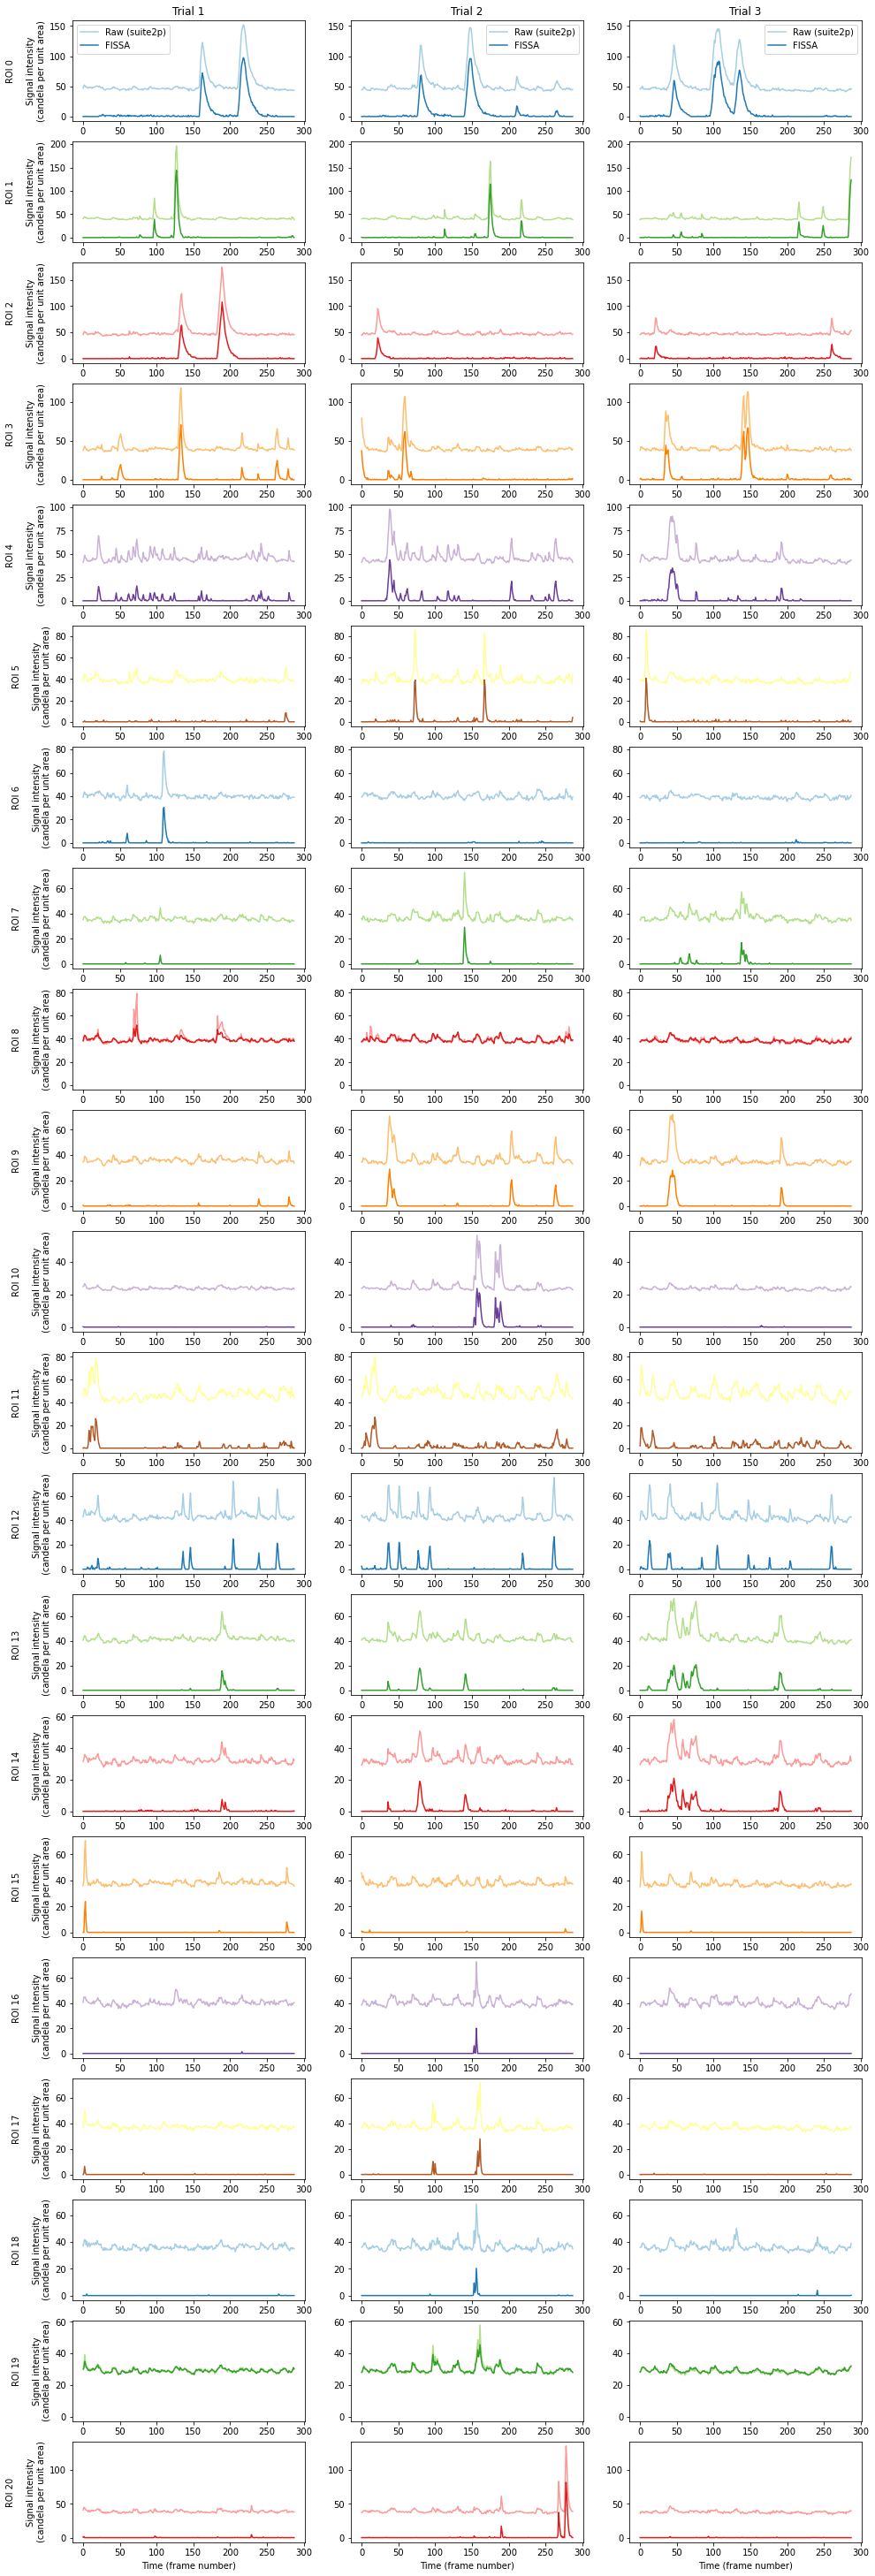

In [7]:
# Plot all ROIs and trials

# Get the number of ROIs and trials
n_roi = experiment.result.shape[0]
n_trial = experiment.result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max_raw = [
    np.max([np.max(experiment.raw[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max([np.max(experiment.result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 2.5 * n_roi))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_roi * n_trial + i_trial
        plt.subplot(n_roi, n_trial, i_subplot)
        # Plot the data
        plt.plot(
            experiment.raw[i_roi][i_trial][0, :],
            label="Raw (suite2p)",
            color=cmap(i_roi * 2 % cmap.N),
        )
        plt.plot(
            experiment.result[i_roi][i_trial][0, :],
            label="FISSA",
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_trial == 0:
            plt.ylabel(
                "ROI {}\n\nSignal intensity\n(candela per unit area)".format(i_roi)
            )
        if i_roi == 0:
            plt.title("Trial {}".format(i_trial + 1))
            plt.legend()

        if i_roi == n_roi - 1:
            plt.xlabel("Time (frame number)")
plt.show()

The figure shows the raw signal from the ROI identified by suite2p (pale), and after decontaminating with FISSA (dark).
The hues match the ROI locations drawn above.
Each row shows the results from one of the ROIs detected by suite2p.
Each column shows the results from one of the three trials.

Note that with the above settings for suite2p it seems to have detected more small local axon signals, instead of cells. This can possibly be improved with manual curation and suite2p setting changes, but as noted above these results should not be seen as indicative for either suite2p or FISSA due to the small dataset size.

Also note that the above Suite2P traces are done without suite2p's own neuropil removal algorithm.